# Optimal Growth

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/julprat/CourseDP_hub/blob/main/Optimal_Growth.ipynb)

## Code

Iteration 50
 Error is 0.13013875164658373

Iteration 100
 Error is 0.01690317836253641

Iteration 150
 Error is 0.002195483316992153

Iteration 200
 Error is 0.000285165329962922

Iteration 226
 Error is 9.86611846087726e-05



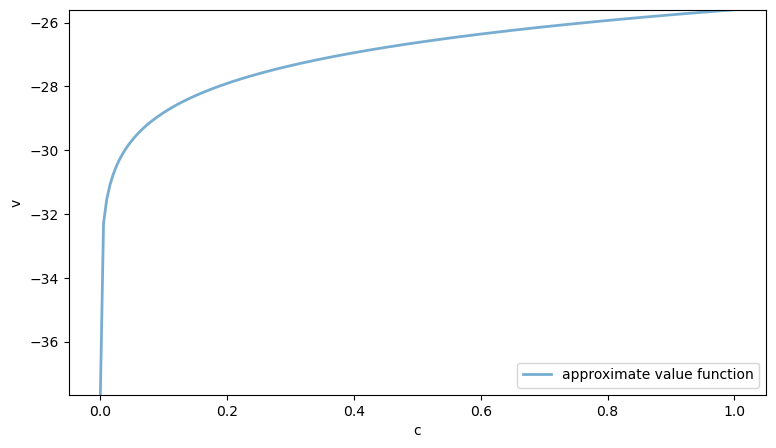

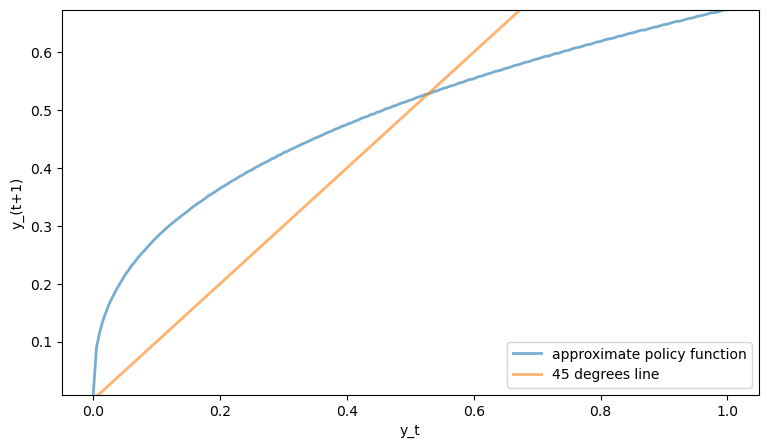

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 18 14:37:30 2018
@author: Bruno
"""

#==============================================================================
# Recursive Methods - Optimal Growth
#==============================================================================

import os
import numpy as np
from scipy.optimize import fminbound


#==============================================================================
# Exercise: U(c) = c^(1-sigma)/(1-sigma) (and send it to Prat)
#==============================================================================


def bellman_operator(w, grid, β, u, f, Tw=None, compute_policy=0):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        σ = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c, y=y):
            return - u(c) - β * w_func(f(y - c))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            #σ[i] = c_star
            #σ[i] = y - c_star #capital at date t
            σ[i] = f(y-c_star) #y_(t+1) as a function of y_t
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, σ
    else:
        return Tw



def solve_optgrowth(initial_w, grid, β, u, f, tol=1e-4, max_iter=500):

    w = initial_w  # Set initial condition
    error = tol + 1
    i = 0

    # == Create storage array for bellman_operator. Reduces  memory
    # allocation and speeds code up == #
    Tw = np.empty(len(grid))

    # Iterate to find solution
    while error > tol and i < max_iter:
        w_new = bellman_operator(w,
                                 grid,
                                 β,
                                 u,
                                 f,
                                 Tw)
        error = np.max(np.abs(w_new - w))
        w[:] = w_new
        i += 1
        print("Iteration "+str(i)+'\n Error is '+str(error)+'\n') if i % 50 == 0 or error < tol else None

        
    # Computes policy
    policy = bellman_operator(w,
                             grid,
                             β,
                             u,
                             f,
                             Tw,
                             compute_policy=1)[1]
 
    return [w, policy]



class CES_OG:
    """
    Constant elasticity of substitution optimal growth model so that

        y = f(k) = k^α


    The class holds parameters and true value and policy functions.
    """

    def __init__(self, α=0.4, β=0.96, sigma=0.9):

        self.α, self.β, self.sigma = α, β, sigma 

    def u(self, c):
        " Utility "
        return (c**(1-self.sigma)-1)/(1-self.sigma)

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.α



# Creation of the model
ces = CES_OG()
# == Unpack parameters / functions for convenience == #
α, β, sigma = ces.α, ces.β, ces.sigma


### Setup of the grid
grid_max = 1         # Largest grid point
grid_size = 200      # Number of grid points
grid = np.linspace(1e-5, grid_max, grid_size)

# Initial conditions and shocks
initial_w = 5 * np.log(grid)


# Computation of the value function
solve = solve_optgrowth(initial_w, grid, β, u=ces.u,
                               f=ces.f, tol=1e-4, max_iter=500)

value_approx = solve[0]
policy_function = solve[1]


#==============================================================================
# Plotting value function
#==============================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(min(value_approx), max(value_approx))
ax.plot(grid, value_approx, lw=2, alpha=0.6, label='approximate value function')
ax.set_xlabel('c')
ax.set_ylabel('v')
ax.legend(loc='lower right')
plt.show()


#==============================================================================
# Plotting Policy function
#==============================================================================

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(min(policy_function), max(policy_function))
ax.plot(grid, policy_function, lw=2, alpha=0.6, label='approximate policy function')

# 45° line
ax.plot(grid, grid, lw=2, alpha=0.6, label='45 degrees line')

ax.set_xlabel('y_t')
ax.set_ylabel('y_(t+1)')
ax.legend(loc='lower right')
plt.show()
